In [149]:
import neuroproof
import neuroproof.FocusedProofreading as fp
import numpy as np
import sys
sys.path.append('../')
sys.path.append('../gp/')

# import gp


In [21]:
import mahotas as mh

In [27]:
  def grab_neighbors(array, label):

      thresholded_array = threshold(array, label)
      thresholded_array_dilated = mh.dilate(thresholded_array.astype(np.uint64))

      copy = np.array(array)
      copy[thresholded_array_dilated != thresholded_array_dilated.max()] = 0
      copy[thresholded_array == 1] = 0

      copy_hist = mh.fullhistogram(copy.astype(np.uint64))

      copy_hist[0] = 0 # ignore zeros
      # copy_hist[label] = 0 # ignore ourselves
      return np.where(copy_hist>0)[0]

  def threshold(array, value):
    '''
    '''
    output_array = np.zeros(array.shape)

    output_array[array == value] = 1

    return output_array

In [105]:
  def generate_M(graph, rhoana, z, min_pixels=100, max=1000, ignore_zero_neighbor=True):
    '''
    '''

    hist = mh.fullhistogram(rhoana.astype(np.uint64))#gp.Util.get_histogram(rhoana.astype(np.uint64))

    
    batch_count = 0

    minlabel = z*100
#     print hist
#     print hist[minlabel:]

    labels = len(list(hist[minlabel:]))
#     print list(labels)
    M = np.zeros((labels,labels), dtype=np.float32)

    for l in range(labels):

        
      if l == 0:
        continue

      if hist[l+minlabel] < min_pixels:
        continue

#       print l
        
      neighbors = sorted(grab_neighbors(rhoana, l+minlabel))

      graph_neighbors = sorted(graph.find_close_bodies(l+minlabel,0,0.))

      pred = [ne[1] for ne in graph_neighbors if ne[0] in neighbors]
        
    
      for i,n in enumerate(neighbors):
            
        if ignore_zero_neighbor and n-minlabel == 0:
          continue

        if hist[n] < min_pixels:
          continue
        n = n-minlabel
#         print l,n,minlabel
        M[l,n] = pred[i]
        M[n,l] = pred[i]

    return M

In [151]:
# from util import Util
from legacy import Legacy

In [169]:
image, prob, gold, rhoana, bb = Legacy.read_dojo_data()


min_pixels = 100
ignore_zero_neighbor = True

bigM = [0]*10
for z in range(10):
    
    rhoana_slice = rhoana[z]
    
    # load graph
    graph = fp.Graph('/home/d/FP/dojoNEW/graph_'+str(z)+'.json')
    
    hist = mh.fullhistogram(rhoana_slice.astype(np.uint64))
    labels = len(hist)
    
    M = np.zeros((labels,labels), dtype=np.float32)
    

    for l in range(labels):

        
        if l == 0:
            continue

        if hist[l] < min_pixels:
            continue

        neighbors = sorted(grab_neighbors(rhoana_slice, l))

        graph_neighbors = sorted(graph.find_close_bodies(l,0,0.))
        pred = [ne[1] for ne in graph_neighbors if ne[0] in neighbors]

        for i,n in enumerate(neighbors):
            
            if ignore_zero_neighbor and n == 0:
                continue

            if hist[n] < min_pixels:
                continue
                
            if pred[i] == 0:
                print 'zeeeero'
            M[l,n] = pred[i]
            M[n,l] = pred[i]
        
    bigM[z] = M

a


In [161]:
with open('/home/d/dojo_xp/data/bigM_fp_2D.p', 'wb') as f:
    pickle.dump(bigM, f)

In [170]:
bigM[0]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.48235291, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.48235291,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.58431375,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.58431375,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

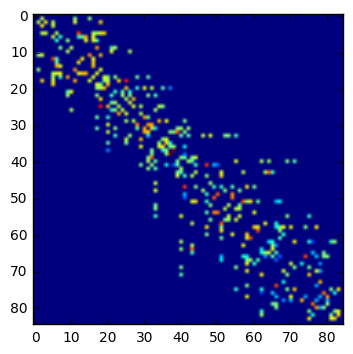

In [171]:
imshow(bigM[0])

In [166]:
with open('/home/d/dojo_xp/data/bigM_new_cnn.p', 'rb') as f:
    gp_bigM = pickle.load(f)

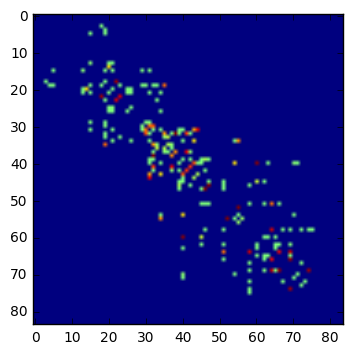

In [168]:
imshow(gp_bigM[1])

In [106]:
M = generate_M(graph, fpseg[1], 1)


In [102]:
M.max()

0.8392157

In [5]:
import h5py

In [6]:
with h5py.File('/home/d/FP/dojo_test_NEW/rhoana.h5', 'r') as hf:
    list_of_names = []
    
    hf.visit(list_of_names.append)
    fpseg = hf['stack'].value

In [7]:
with h5py.File('/home/d/FP/dojo_test_NEW/segmentation.h5', 'r') as hf:
    list_of_names = []
    
    hf.visit(list_of_names.append)
    fpseg2 = hf['stack'].value

In [132]:
with h5py.File('/home/d/FP/dojo_test/rhoana.h5', 'r') as hf:
    list_of_names = []
    
    hf.visit(list_of_names.append)
    fpsega = hf['stack'].value

In [11]:

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
bigM = []
for z in range(fpseg.shape[0]):
    M = generate_M(graph, fpseg[z], z)
    bigM.append(M)
    print 'stored z=',z

stored z= 0
stored z= 1
stored z= 2
stored z= 3
stored z= 4
stored z= 5
stored z= 6
stored z= 7
stored z= 8
stored z= 9


In [36]:
import cPickle as pickle

In [109]:
with open('/home/d/dojo_xp/data/bigM_fp_NEW.p', 'wb') as f:
    pickle.dump(bigM, f)

In [33]:
zmax = -1
for z in range(10):
    
    zmax = max(zmax, bigM[z].max())

In [34]:
zmax

0.8509804

In [108]:
bigM[9].max()

0.85490197

In [177]:
#
# create bigM for the cylinder
#

import glob, os, skimage


def normalize_labels(array):
    '''
    '''
    return mh.labeled.relabel(array)


def relabel(array):

    relabeled_array = np.array(array)

    relabeled_array = skimage.measure.label(array).astype(np.uint64)
    # relabeled_array[relabeled_array==0] = relabeled_array.max()

    return normalize_labels(relabeled_array)[0]

min_pixels = 100
ignore_zero_neighbor = True

bigM = [0]*50
for z in range(250,299):
    
    mask = sorted(glob.glob(os.path.join('/home/d/data/cylinderNEW', 'mask', '*'+str(z)+'.png')))   
    mask = mh.imread(mask[0]).astype(np.bool)
    
    rhoana = sorted(glob.glob(os.path.join('/home/d/data/cylinderNEW', 'rhoana', '*'+str(z)+'.png')))
    rhoana = mh.imread(rhoana[0])
    rhoana_single = np.zeros((rhoana.shape[0], rhoana.shape[1]), dtype=np.uint64)
    rhoana_single[:, :] = rhoana[:,:,0]*256*256 + rhoana[:,:,1]*256 + rhoana[:,:,2]    
    
    rhoana_single = relabel(rhoana_single)
    
    rhoana_single[mask==0] = 0
    
    rhoana_slice = rhoana_single
    
    # load graph
    graph = fp.Graph('/home/d/FP/cylinder/graph_'+str(z)+'.json')
    
    hist = mh.fullhistogram(rhoana_slice.astype(np.uint64))
    labels = len(hist)
    
    M = np.zeros((labels,labels), dtype=np.float32)
    

    for l in range(labels):

        
        if l == 0:
            continue

        if hist[l] < min_pixels:
            continue

        neighbors = sorted(grab_neighbors(rhoana_slice, l))

        graph_neighbors = sorted(graph.find_close_bodies(l,0,0.))
        pred = [ne[1] for ne in graph_neighbors if ne[0] in neighbors]

        for i,n in enumerate(neighbors):
            
            if ignore_zero_neighbor and n == 0:
                continue

            if hist[n] < min_pixels:
                continue
                
            if pred[i] == 0:
                print 'zeeeero'
            M[l,n] = pred[i]
            M[n,l] = pred[i]
        
    bigM[z-250] = M
    print z

250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298


In [178]:
bigM[-1] = np.zeros((1,1))
with open('/home/d/FP/cylinder/bigM_fp.p', 'wb') as f:
    pickle.dump(bigM, f)